# Module

In [1]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

plt.style.use("seaborn-v0_8-white")
pd.set_option("display.max_columns", 50)


# Data

In [2]:
data_path = "./data/"

sales_train = pd.read_csv(data_path + 'sales_train.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
shops = pd.read_csv(data_path + 'shops.csv')
test = pd.read_csv(data_path + 'test.csv')

# item name

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9а-яА-Я\s]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
items['cleaned_item_name'] = items['item_name'].apply(clean_text)
items.head()

,item_name,item_id,item_category_id,cleaned_item_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ d
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло d


In [5]:
all_words = ' '.join(items['cleaned_item_name'].values).split()
Counter(all_words).most_common(50)

[('версия', 3599),
 ('pc', 2683),
 ('bd', 2322),
 ('цифровая', 2003),
 ('регион', 1849),
 ('2', 1821),
 ('русская', 1452),
 ('jewel', 1370),
 ('и', 1251),
 ('1', 1244),
 ('the', 1185),
 ('3', 1133),
 ('1с', 1120),
 ('cd', 1019),
 ('of', 955),
 ('в', 949),
 ('mp3', 948),
 ('dvd', 899),
 ('фирм', 757),
 ('xbox', 754),
 ('ps3', 735),
 ('edition', 681),
 ('фигурка', 667),
 ('для', 638),
 ('s', 615),
 ('коллекция', 576),
 ('360', 571),
 ('3d', 566),
 ('digipack', 553),
 ('4', 551),
 ('на', 535),
 ('lp', 524),
 ('с', 504),
 ('арт', 465),
 ('2cd', 452),
 ('a', 437),
 ('русские', 420),
 ('игра', 418),
 ('сб', 406),
 ('субтитры', 402),
 ('7', 367),
 ('v', 367),
 ('5', 356),
 ('футболка', 356),
 ('игрушка', 352),
 ('английская', 345),
 ('box', 336),
 ('набор', 334),
 ('8', 332),
 ('издание', 308)]

- 대상이 되는 1C COMPANY는 게임 소프트웨어를 취급하는 러시아 기업
- pc(2위), цифровая(디지털, 4위) -> 디지털 다운로드는 cd/dvd 제품과 판매형태가 전혀 다름. 온라인 위주로 판매될 것
- xbox(19위), ps3는 콘솔게임기고 360(46위)도 xbox360 콘솔을 지칭하는 것으로 추정됨
- jewel(8위, 저가판), dvd(18위), cd(14위), bd(블루레이 디스크, 3위), box(47위), edition(41위) 등은 제품형태를 뜻하는 걸로 보임
    - 상대적으로 저렴한 저가판의 판매가 많고, 고가의 에디션은 판매량이 상대적으로 적을 것으로 추정
- фигурка (피규어, 23위), футболка (티셔츠, 44위), игрушка (장난감, 45위) -> 게임 및 콘솔과 판매 패턴이 다를 것

# platform, meta_type

In [6]:
def get_platform(name):
    if 'pc' in name or 'пк' in name: return 'PC'
    if 'ps3' in name: return 'PS3'
    if 'ps4' in name: return 'PS4'
    if 'xbox' in name or 'x360' in name: return 'Xbox' # 360도 Xbox로 통합
    if 'psp' in name: return 'PSP'
    if 'vita' in name or 'psv' in name: return 'PSVita'
    if 'wii' in name: return 'Wii'
    if 'mac' in name: return 'Mac'
    if 'android' in name: return 'Android'
    return 'Etc'


def get_meta_type(name):
    # 디지털/버전 정보
    if 'цифровая' in name or 'digital' in name: return 'Digital'
    if 'версия' in name: return 'Version' # Version 보통 일반판
    
    # 실물 미디어
    if 'bd' in name or 'blu-ray' in name: return 'BluRay'
    if 'dvd' in name: return 'DVD'
    if 'cd' in name: return 'CD'
    if 'lp' in name: return 'Vinyl'
    
    # 패키지 형태
    if 'jewel' in name: return 'Jewel' # 저가판
    if 'region' in name or 'регион' in name: return 'Region' # 현지화/지역한정
    if 'edition' in name or 'издание' in name: return 'Edition' # 특별판 등
    if 'box' in name: return 'Box'
    
    # 4. 굿즈
    if 'фигурка' in name: return 'Figure'
    if 'футболка' in name: return 'TShirt'
    if 'игрушка' in name: return 'Toy'
    if 'арт' in name: return 'Art'
    
    return 'Normal'


items['platform_type'] = items['cleaned_item_name'].apply(get_platform)
items['meta_type'] = items['cleaned_item_name'].apply(get_meta_type)

In [7]:
items['platform_type'].value_counts()

platform_type
Etc        17397
PC          2799
Xbox         747
PS3          719
PS4          205
PSP          147
PSVita        93
Mac           52
Android       11
Name: count, dtype: int64

In [8]:
items['meta_type'].value_counts()

meta_type
Normal     8188
BluRay     2279
Digital    2005
Region     1828
Version    1563
CD         1401
DVD        1041
Vinyl       789
Figure      662
Art         551
Jewel       490
Box         406
Toy         348
TShirt      348
Edition     271
Name: count, dtype: int64

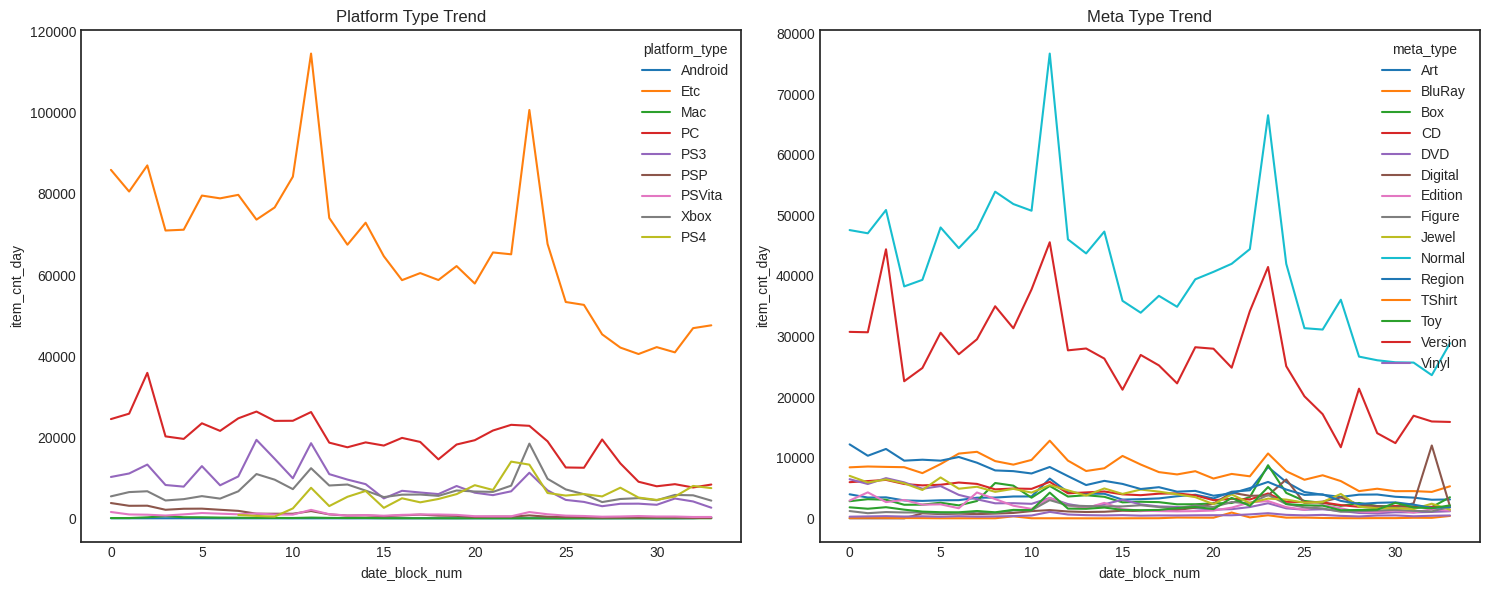

In [9]:
group_platform = sales_train.merge(items[['item_id', 'platform_type']], on='item_id', how='left')
platform_trend = group_platform.groupby(['date_block_num', 'platform_type'])['item_cnt_day'].sum().reset_index()
group_meta = sales_train.merge(items[['item_id', 'meta_type']], on='item_id', how='left')
meta_trend = group_meta.groupby(['date_block_num', 'meta_type'])['item_cnt_day'].sum().reset_index()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.lineplot(data=platform_trend, x='date_block_num', y='item_cnt_day', hue='platform_type', palette='tab10', ax=ax[0])
sns.lineplot(data=meta_trend, x='date_block_num', y='item_cnt_day', hue='meta_type', palette='tab10', ax=ax[1])
ax[0].set_title('Platform Type Trend')
ax[1].set_title('Meta Type Trend')
plt.tight_layout()
plt.show()

# Item Category

In [10]:
 # 카테고리 내 아이템 수
 # 1: 10, 51, 79 // 2: 1, 50 // 3: 26, 52, 53 // 
pd.set_option('display.max_rows', None)
print(item_categories['item_category_name'])

0                      PC - Гарнитуры/Наушники
1                             Аксессуары - PS2
2                             Аксессуары - PS3
3                             Аксессуары - PS4
4                             Аксессуары - PSP
5                          Аксессуары - PSVita
6                        Аксессуары - XBOX 360
7                        Аксессуары - XBOX ONE
8                               Билеты (Цифра)
9                              Доставка товара
10                       Игровые консоли - PS2
11                       Игровые консоли - PS3
12                       Игровые консоли - PS4
13                       Игровые консоли - PSP
14                    Игровые консоли - PSVita
15                  Игровые консоли - XBOX 360
16                  Игровые консоли - XBOX ONE
17                    Игровые консоли - Прочие
18                                  Игры - PS2
19                                  Игры - PS3
20                                  Игры - PS4
21           

In [11]:
def process_category_names(item_cats):
    # ' - ' 기준으로 대분류(type)와 소분류(subtype) 분리
    item_cats['split'] = item_cats['item_category_name'].str.split('-')
    item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
    item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
    
    # 러시아어 대분류 -> 영어 대분류 매핑
    type_map = {
        'PC': 'PC',
        'Аксессуары': 'Accessories',
        'Билеты (Цифра)': 'Tickets (Digital)',       # 삭제하거나 기타로 분류
        'Доставка товара': 'Delivery',               # 삭제 후보 
        'Игровые консоли': 'Consoles',
        'Игры': 'Games',
        'Игры Android': 'Games Android',
        'Игры MAC': 'Games MAC',
        'Игры PC': 'Games PC',
        'Карты оплаты': 'Payment Cards',             # 통합 후보
        'Карты оплаты (Кино, Музыка, Игры)': 'Payment Cards', # 통합 후보
        'Кино': 'Movies',
        'Книги': 'Books',
        'Музыка': 'Music',
        'Подарки': 'Gifts',
        'Программы': 'Software',
        'Служебные': 'Service',                      # 삭제 후보
        'Чистые носители (шпиль)': 'Blank Media',    # 통합 후보
        'Чистые носители (штучные)': 'Blank Media',  # 통합 후보
        'Элементы питания': 'Batteries'
    }
    
    # 매핑 적용 (매핑되지 않은 것은 'Etc'로 처리)
    item_cats['type_code'] = item_cats['type'].map(type_map)
    item_cats['type_code'] = item_cats['type_code'].fillna('Etc')
    item_cats = item_cats[['item_category_id', 'item_category_name', 'type_code', 'subtype']]
    return item_cats


item_categories = process_category_names(item_categories)

print(item_categories[['item_category_id', 'type_code', 'subtype']].head(10))
print("\n=== 대분류별 카테고리 개수 ===")
print(item_categories['type_code'].value_counts())

   item_category_id          type_code             subtype
0                 0                 PC  Гарнитуры/Наушники
1                 1        Accessories                 PS2
2                 2        Accessories                 PS3
3                 3        Accessories                 PS4
4                 4        Accessories                 PSP
5                 5        Accessories              PSVita
6                 6        Accessories            XBOX 360
7                 7        Accessories            XBOX ONE
8                 8  Tickets (Digital)      Билеты (Цифра)
9                 9           Delivery     Доставка товара

=== 대분류별 카테고리 개수 ===
type_code
Books                13
Gifts                12
Consoles              8
Games                 8
Accessories           7
Music                 6
Software              6
Payment Cards         5
Movies                5
Games PC              4
Blank Media           2
Service               2
PC                    1
Games M

In [12]:
df = items.merge(item_categories, on='item_category_id', how='left')
df.groupby('item_category_id')['item_id'].nunique().reset_index()

,item_category_id,item_id
0,0,4
1,1,2
2,2,75
3,3,34
4,4,15
5,5,29
6,6,40
7,7,24
8,8,9
9,9,12


- 10, 51, 79번 카테고리엔 아이템이 1개만 존재

In [14]:
items[items['item_category_id'].isin([10, 51, 79])]

,item_name,item_id,item_category_id,cleaned_item_name,platform_type,meta_type
6669,Sony PlayStation 2 (SCPH-77008),6669,10,sony playstation 2 scph 77008,Etc,Normal
17703,Правила дорожного движения 2009. Новейшая мето...,17703,51,правила дорожного движения 2009 новейшая метод...,Etc,CD
17717,Прием денежных средств для 1С-Онлайн,17717,79,прием денежных средств для 1с онлайн,Etc,Normal


In [15]:
item_categories.loc[item_categories['item_category_id'].isin([10, 51, 79])]

,item_category_id,item_category_name,type_code,subtype
10,10,Игровые консоли - PS2,Consoles,PS2
51,51,Книги - Познавательная литература,Books,Познавательная литература
79,79,Служебные,Service,Служебные


In [16]:
test[test['item_id'].isin([6669,17703,17717])]

,ID,shop_id,item_id
274,274,5,17717
5374,5374,4,17717
10474,10474,6,17717
15574,15574,3,17717
20674,20674,2,17717
25774,25774,7,17717
30874,30874,10,17717
35974,35974,12,17717
41074,41074,28,17717
46174,46174,31,17717


In [ ]:
df = test.merge(items, on='item_id', how='left')
df = df.merge(item_categories, on='item_category_id', how='left')
print(len(df.loc[df['item_category_id'].isin([79])]))
df.loc[df['item_category_id'].isin([79])].head()

42


,ID,shop_id,item_id,item_name,item_category_id,cleaned_item_name,platform_type,meta_type,item_category_name,type_code,subtype
274,274,5,17717,Прием денежных средств для 1С-Онлайн,79,прием денежных средств для 1с онлайн,Etc,Normal,Служебные,Service,Служебные
5374,5374,4,17717,Прием денежных средств для 1С-Онлайн,79,прием денежных средств для 1с онлайн,Etc,Normal,Служебные,Service,Служебные
10474,10474,6,17717,Прием денежных средств для 1С-Онлайн,79,прием денежных средств для 1с онлайн,Etc,Normal,Служебные,Service,Служебные
15574,15574,3,17717,Прием денежных средств для 1С-Онлайн,79,прием денежных средств для 1с онлайн,Etc,Normal,Служебные,Service,Служебные
20674,20674,2,17717,Прием денежных средств для 1С-Онлайн,79,прием денежных средств для 1с онлайн,Etc,Normal,Служебные,Service,Служебные


- 10, 51은 테스트셋에 존재하지 않음 -> 훈련데이터에서 삭제